# Extracción de Tweets usando Snscrape



# Scraping Twitter Using snscrape
<br>Package Github: https://github.com/JustAnotherArchivist/snscrape
<br>This notebook will be using the development version of snscrape

Article Read-Along: https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af

### Author: Martin Beck

<b>Dependencies: </b> 
- Your <b>Python</b> version must be <b>3.8</b> or higher. The development version of snscrape will not work with Python 3.7 or lower. You can download the latest Python version [here](https://www.python.org/downloads/).
- <b>Development version of snscrape</b>, uncomment the pip install line in the below cell to pip install in the notebook if you don't already have it.
- <b>Pandas</b>, the dataframes allows easy manipulation and indexing of data, this is more of a preference but is what I follow in this notebook.

In [ ]:
#!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

# Imports
import os
import pandas as pd
import itertools
import snscrape.modules.twitter as sntwitter

# Consulta por búsqueda de texto
El siguiente código buscará tweets a través de los siguientes términos:

* 'Dolor vacuna'
* 'efecto vacuna', 'efecto astrazeneca', etc.
* 'reacción vacuna'
* 'vacuna #AstraZeneca', 'vacuna #Sputnik', 'vacuna #j&j', etc.
* sputnik v, moderna
* 'vacuna sintoma'
* etc.

La búsqueda será de los años 2020, 2021 y 2022, y que serán almacenados en un archivo CSV

In [ ]:
latitud = '19.309917325231165'   
longitud = '-99.12243737329997'
#radio de distancia a partir de 4
radio = '31.28km' 

localizacion = latitud + ',' + longitud + ',' + radio

#tweet_count = 100

#df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    #'efecto vacuna since:2022-01-01 until:2022-01-31 geocode:"{}"'.format(localizacion)).get_items(),tweet_count))[['id','url','date','content','likeCount','retweetCount']]

df_tw = pd.DataFrame((sntwitter.TwitterSearchScraper(
    'mi vacuna since:2020-12-24 until:2022-09-25 geocode:"{}"'.format(localizacion)).get_items()))[['id','url','date','content','likeCount','retweetCount','replyCount','coordinates','place']]

df_tw['latitud'] = latitud
df_tw['longitud'] = longitud
df_tw['radio'] = radio

df_tw.to_csv('mi_vacuna.csv', sep=',', index=False,mode="w+")

# Pre-procesamiento

In [ ]:
import re
#!pip install emoji
import emoji
import pandas as pd
import numpy as np
#!pip install unidecode
from unidecode import unidecode

import nltk 
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!pip install pyspellchecker
from spellchecker import SpellChecker

#!pip install spacy
import spacy
#!python -m spacy download es
#nlp = spacy.load('es_core_news_sm')

#!pip install stanza
import stanza
nlp = stanza.Pipeline('es',processors='tokenize,mwt,lemma')

In [ ]:
nombre_archivo = "dataset_efectos_vacuna_covid_6.csv"

df_tw = pd.read_csv(nombre_archivo)
df_tw.head()

In [ ]:
def remover_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet)   # quitar http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # quitar bitly links
    tweet = tweet.strip('[link]')   # quitar [links]
    
    return tweet

def remover_menciones(tweet):
    tweet = re.sub(r"@\S+", "", tweet)
    
    return tweet

def rep(m):
    s = m.group(1)
    return ' '.join(re.split(r'(?=[A-Z])', s))

def separar_palabras_hashtag(tweet):
    tweet = re.sub(r'#(\w+)', rep, tweet)
    
    return tweet

def separar_numeros_de_letras(tweet):
    tweet = re.findall(r'\D+|\d+', tweet)
    
    return lista_a_cadena(tweet)
    
def remover_hashtag(tweet):  
    tweet = re.sub(r'#', '', tweet)
    
    return tweet

def arreglar_abreviaciones(tweet):
    palabras = tweet.split()

    abreviaciones = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
                'srta':'señorita',
               'm': 'me',
               'aprox': 'aproximadamente',
               'hrs': 'horas',
                '1er': 'primer',
                '1era': 'primera',
                '1ra' : 'primera',
                '1ra': 'primera',
                '2do': 'segundo',
                '2da': 'segunda',
                '3er': 'tercer',
                '3ero': 'tercero',
                '3era': 'tercera',
                '3ra' : 'tercera',
                'jj': 'johnson',
                'amixs': 'amigos',
                'pos': 'pues',
                'ok': 'está bien',
                'lit': 'literal',
                'vs': 'contra',
                'ptm': 'puta madre',
                'alch': 'al chile',
                'desminulleron' : 'disminuyeron',
                'días': 'día',
                'kg': 'kilogramo',
                'mg': 'miligramo',
                'echo' : 'hecho',
                'mins' : 'minutos',
                'min' : 'minuto',
                'pa': 'para',
                'holi' : 'hola',
                'am' : 'antes del mediodia',
                'pm' : 'despues del mediodia',
                'desminulleron' : 'disminuyeron',
                'vrsh' : 'vete al diablo',
                'chxngxdx' : 'chingados'}
    
        
    tweet = " ".join([abreviaciones[palabra] if palabra in abreviaciones.keys() else palabra for palabra in palabras])

    return tweet


def arreglar_nombres_vacunas(tweet):
    i = 0
    
    palabras = tweet.split()
    
    tamañio = len(palabras)
    
    for palabra in palabras:
        #normaliza el nombre de la vacuna inglesa
        if palabra == 'astra':
            palabras[i] = 'astrazeneca'
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'zeneca':
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
                elif palabras[i + 1] == 'seneca':
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
        elif palabra == 'aztra':
            palabras[i] = 'astrazeneca'
            
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'zeneca':
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'seneca':
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
        elif palabra == 'zeneca':
            palabras[i] = 'astrazeneca'
        
        elif palabra == 'aztrazeneca':
            palabras[i] = 'astrazeneca'
            
        elif palabra == 'astrazeneca':
            palabras[i] = 'astrazeneca'
            
        elif palabra == 'aztraceneca':
            palabras[i] = 'astrazeneca'
            
        elif palabra == 'astraseneca':
            palabras[i] = 'astrazeneca'
            
        i+=1
    
    return lista_a_cadena(palabras)
    
def remover_estilos(tweet):  
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    return tweet

def remover_numeros(tweet):
    tweet = re.sub(r'[0-9]', '', tweet)
    
    return tweet

def minusculas(tweet):
    tweet = tweet.lower()
    
    return tweet

def remover_puntuaciones(tweet):
    puntuaciones = '!"$%&\'()*+,-./:;<=>¿?[\\]^_`{|}~•@º'
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet) 
    
    #Remover comillas
    tweet = tweet.replace("’", "")
    tweet = tweet.replace("“", '')
    tweet = tweet.replace("”", '')
    
    #Remover puntos de suspensión
    tweet = tweet.replace('\u2026', '')
    
    return tweet

def remover_espacios(tweet):
    tweet = re.sub('\s+', ' ', tweet)
    
    return tweet

def remover_emojis(tweet):
    tweet = emoji.replace_emoji(tweet, replace='')
    #tweet = re.sub(emoji.get_emoji_regexp(), r"", tweet)
    
    return tweet

def remover_letras_repetidas(tweet):
    tweet = re.sub(r'(.)\1{2,}',r'\1', tweet)
    
    return tweet

def remover_signos_diacríticos(tweet):
    #Conversión de la letra ñ a n
    tweet = re.sub(u"[ñ]", 'n', tweet)
    
    #Remover signos diacríticos
    tweet = unidecode(tweet)
    
    return tweet

def tokenizar(tweet):
    tk = TweetTokenizer()
    tweet_tokenizado = tk.tokenize(tweet) 
    
    return tweet_tokenizado

def remover_stopwords(tweet_tokenizado):   
    with open('stopwords.txt', encoding='utf-8') as f:
        palabras_auxiliares = f.read().splitlines()
        
    stop_words = stopwords.words('spanish')
    
    for palabra in palabras_auxiliares:
        stop_words.append(palabra)
        
    tweet_tokenizado = [palabra for palabra in tweet_tokenizado if palabra not in stop_words]
    
    return lista_a_cadena(tweet_tokenizado)

def remover_único_token(tweet): 
    tweet_tokenizado = tokenizar(tweet)
    
    for palabra in tweet_tokenizado:
        if len(palabra) == 1 :
            tweet_tokenizado.remove(palabra)
            
    return tweet_tokenizado

def corrector_otográfico(tweet):
    spell = SpellChecker(language='es')
    
    #Agrega nuevos términos al corrector ortográfico
    spell.word_frequency.load_text_file('terminos.txt')

    spell.word_frequency.load_words(['covid','sputnik', 'astrazeneca','pfizer','biontech','pfizerbiontech',
                                    'cansino','moderna','janssen','johnson','booster','imss','gatell','gatel','sars',
                                     'cov','gripita', 'sarscov'])
        
    k = 0
    
    for palabra in tweet:
        palabra_correcta = spell.correction(palabra)
        tweet[k] = palabra_correcta
        
        k+=1 
        
    return lista_a_cadena(tweet)

def lista_a_cadena(s):
    str1 = " "
   
    return (str1.join(s))

def lematizar(tweet_tokenizado):
    doc = nlp(tweet_tokenizado)
            
    lista = []

    for oracion in doc.sentences:
        for palabra in oracion.words:
            if palabra.text == 'gatell':
                lista.append('gatell')
            elif palabra.text == 'sars':
                lista.append('sars')
            elif palabra.text == 'coronavirus':
                lista.append('coronavirus')    
            elif palabra.text == 'tos':
                lista.append('tos')
            elif palabra.text == 'moderna':
                lista.append('moderna')
            elif palabra.text == 'vacunación':
                lista.append('vacuna')
            elif palabra.text == 'vacunacion':
                lista.append('vacuna')
            elif palabra.text == 'vacunar':
                lista.append('vacuna')
            elif palabra.text == 'vacunado':
                lista.append('vacuna')
            elif palabra.text == 'vacunados':
                lista.append('vacuna')
            elif palabra.text == 'vacunen':
                lista.append('vacuna')
            elif palabra.text == 'vacunaron':
                lista.append('vacuna')
            elif palabra.text == 'vacuno':
                lista.append('vacuna')
            elif palabra.text == 'vacunamos':
                lista.append('vacuna')
            elif palabra.text == 'vacuné':
                lista.append('vacuna')
            elif palabra.text == 'vacune':
                lista.append('vacuna')
            elif palabra.text == 'vacunan':
                lista.append('vacuna')
            elif palabra.text == 'vacunó':
                lista.append('vacuna')
            elif palabra.text == 'vacunaron':
                lista.append('vacuna')
            elif palabra.text == 'vacunaste':
                lista.append('vacuna') 
            elif palabra.text == 'doloroso':
                lista.append('dolor')
            elif palabra.text == 'dolorosa':
                lista.append('dolor')
            elif palabra.text == 'dolorido':
                lista.append('dolor')
            elif palabra.text == 'dolido':
                lista.append('dolor')
            elif palabra.text == 'dolorosamente':
                lista.append('dolor')
            elif palabra.text == 'dolorimiento':
                lista.append('dolor')
            elif palabra.text == 'adolorido':
                lista.append('dolor')
            elif palabra.text == 'adolorida':
                lista.append('dolor')
            else:
                lema = palabra.lemma
                
                if lema == 'doler' or lema == 'dolerme':
                    lema = 'dolor'
                
                if not (lema == 'él' or lema == 'yo'):
                    lista.append(lema)

    return lista       

In [ ]:
content = df_tw['rawContent']
lista_tokens = []

for i in range(len(content)):
    tweet = content[i]
    tweet = remover_links(tweet)
    tweet = remover_menciones(tweet)
    tweet = remover_estilos(tweet)
    tweet = separar_palabras_hashtag(tweet)
    tweet = minusculas(tweet)
    tweet = remover_puntuaciones(tweet)
    tweet = remover_espacios(tweet)
    tweet = remover_emojis(tweet)
    tweet = remover_letras_repetidas(tweet)
    tweet = arreglar_abreviaciones(tweet)
    tweet = separar_numeros_de_letras(tweet)
    tweet = remover_numeros(tweet)
    tweet = arreglar_abreviaciones(tweet)
    tweet = arreglar_nombres_vacunas(tweet)
    tweet_tokenizado = tokenizar(tweet)
    tweet_tokenizado = corrector_otográfico(tweet_tokenizado)
    tweet_tokenizado = lematizar(tweet_tokenizado)
    tweet_tokenizado = remover_stopwords(tweet_tokenizado)
    tweet_tokenizado = remover_signos_diacríticos(tweet_tokenizado)
    tweet_tokenizado = remover_único_token(tweet_tokenizado) 
    
    lista_tokens.append(tweet_tokenizado)

In [ ]:
l = ["Tercerda dosis de #AstraZeneca ayer. La primera escalofríos, dolor muscular, articular, no tan mal. La segunda algo de cansancio. La tercera limpia (al menos 24 horas después). 🙃",
    "Dos días de que me pusieron mi segunda dosis de vacuna #AstraZeneca y vuelvo a despertar con dolor de cabeza 😩😩😩"]

lista_tokens = []

for i in range(len(l)):
    tweet = l[i]
    tweet = remover_links(tweet)
    tweet = remover_menciones(tweet)
    tweet = remover_estilos(tweet)
    tweet = separar_palabras_hashtag(tweet)
    tweet = minusculas(tweet)
    tweet = remover_puntuaciones(tweet)
    tweet = remover_espacios(tweet)
    tweet = remover_emojis(tweet)
    tweet = remover_letras_repetidas(tweet)
    tweet = arreglar_abreviaciones(tweet)
    tweet = separar_numeros_de_letras(tweet)
    tweet = remover_numeros(tweet)
    tweet = arreglar_abreviaciones(tweet)
    tweet = arreglar_nombres_vacunas(tweet)
    tweet_tokenizado = tokenizar(tweet)
    tweet_tokenizado = corrector_otográfico(tweet_tokenizado)
    tweet_tokenizado = lematizar(tweet_tokenizado) 
    tweet_tokenizado = remover_stopwords(tweet_tokenizado)
    tweet_tokenizado = remover_signos_diacríticos(tweet_tokenizado)
    tweet_tokenizado = remover_único_token(tweet_tokenizado)
    
    lista_tokens.append(tweet_tokenizado)
    
print(lista_tokens)

In [ ]:
termino = " ".join(nombre_archivo.split(".")[0].split("_"))
df_tw['palabra_clave'] = termino

df_tw['tweet_tokenizado'] = lista_tokens

df_tw.to_csv(nombre_archivo, sep=',', index=False,mode="w+")

# Separación de fecha

In [ ]:
import pytz
from datetime import datetime
import pandas as pd

df_tw = pd.read_csv('dataset_efectos_vacuna_covid_6.csv')

dates = df_tw['date']

dias = []
meses = []
años = []

for date in dates:
    fecha_utc = datetime.fromisoformat(date)

    ciudad_de_méxico = pytz.timezone('America/Mexico_City')
    fecha_cdmx = fecha_utc.astimezone(ciudad_de_méxico)
    
    fecha_dividida = fecha_cdmx.strftime('%Y-%m-%d').split('-')
    
    dias.append(fecha_dividida[2])
    meses.append(fecha_dividida[1])
    años.append(fecha_dividida[0])
    
df_tw['dias'] = dias
df_tw['meses'] = meses 
df_tw['años'] = años

df_tw.drop(['date'], axis = 1, inplace = True)
df_tw.to_csv('dataset_efectos_vacuna_covid_6.csv', index = False)

# Geolocalización

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

df = pd.read_csv('nv_dataset_vacuna.csv')

lugares = df['place']
coordenadas = df['coordinates']
terminos = df['termino']

dicc_alcaldias = {'Azcapotzalco' : " ", 'Coyoacán' : " ", 'Cuajimalpa de Morelos' : " ", 'Gustavo A. Madero' : " ",
                  'Iztacalco' : " ", 'Iztapalapa' : " ", 'La Magdalena Contreras' : " ", 'Milpa Alta' : " ",
                  'Álvaro Obregón' : " ", 'Tláhuac': " ", 'Tlalpan' : " ", 'Xochimilco' : " ", 'Benito Juárez' : " ",
                  'Cuauhtémoc' : " ", 'Miguel Hidalgo' : " ", 'Venustiano Carranza' : " "}

geolocator = Nominatim(user_agent="http")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

latitudes = []
longitudes = []

ndf = pd.DataFrame(columns=df.columns)
ndf['latitudes'] = 0
ndf['longitudes'] = 0
ndf['alcaldia'] = " "

for i, lugar in enumerate(lugares):
    if not pd.isna(lugar):
        dicc = eval(lugar)
        
        dirección = dicc['fullName']
        ubicación = dicc['fullName'].split(',')
        alcaldia = ubicación[0].strip()
        
        if alcaldia in dicc_alcaldias:
            if dicc_alcaldias[alcaldia] == " ":
                localización = geolocator.geocode(dirección, timeout=None)
                dicc_alcaldias[alcaldia] = str(localización.latitude) + "," + str(localización.longitude)

                
                fila = df.iloc[i]
                ndf = ndf.append(fila)
                
                ndf.loc[i,'latitudes'] = localización.latitude
                ndf.loc[i,'longitudes'] = localización.longitude
                ndf.loc[i,'alcaldia'] = alcaldia
                
            else:
                coordenada = dicc_alcaldias[alcaldia]
                separación_coordenada = coordenada.split(',')
                
                fila = df.iloc[i]
                ndf = ndf.append(fila)
                
                ndf.loc[i,'latitudes'] = separación_coordenada[0].strip()
                ndf.loc[i,'longitudes'] = separación_coordenada[1].strip()
                ndf.loc[i,'alcaldia'] = alcaldia
        else:
            print(i)
            dicc = eval(coordenadas[i])
            latitud = dicc['latitude']
            longitud = dicc['longitude']
    
            localización = str(latitud) + ', ' + str(longitud) 
            ubicación = reverse((localización), language='es', exactly_one=True, timeout=None)
            #print(i)    
            if ubicación != None:
                for alcaldia in dicc_alcaldias.keys():
                    if alcaldia in ubicación.address:
                        fila = df.iloc[i]
                        ndf = ndf.append(fila)

                        ndf.loc[i,'latitudes'] = latitud
                        ndf.loc[i,'longitudes'] = longitud
                        ndf.loc[i,'alcaldia'] = alcaldia

                        break
                        
            time.sleep(1)
    else:
        for alcaldia in dicc_alcaldias.keys():
            if alcaldia in terminos[i]:   
                if dicc_alcaldias[alcaldia] == " ":
                    ubicación = alcaldia + ", " + "Distrito Federal"
                    localización = geolocator.geocode(ubicación, timeout=None)
                    dicc_alcaldias[alcaldia] = str(localización.latitude) + "," + str(localización.longitude)
                
                    fila = df.iloc[i]
                    ndf = ndf.append(fila)
                    
                    ndf.loc[i,'latitudes'] = localización.latitude
                    ndf.loc[i,'longitudes'] = localización.longitude
                    ndf.loc[i,'alcaldia'] = alcaldia
                    
                else:
                    coordenada = dicc_alcaldias[alcaldia]
                    separación_coordenada = coordenada.split(',')
                    
                    fila = df.iloc[i]
                    ndf = ndf.append(fila)
                    
                    ndf.loc[i,'latitudes'] = separación_coordenada[0].strip()
                    ndf.loc[i,'longitudes'] = separación_coordenada[1].strip()
                    ndf.loc[i,'alcaldia'] = alcaldia
                    
                break

#print(ndf.head())
ndf.to_csv('nuevo_dataset.csv',index=False,encoding='utf-8') 

# Carga del dataset

In [1]:
import pandas as pd
import regex as re

df_tw = pd.read_csv("dataset_efectos_vacuna_covid_final.csv", encoding='latin-1')

#my_string = df_tw['content'][50]
#string_decoded = my_string.encode('latin-1').decode('utf-8')
#print(string_decoded)

# Frecuencias de palabras

In [2]:
#import numpy as np
import regex as re

tokens = df_tw['tweet_tokenizado']

puntuaciones = "]'["
lista_tokens = []
tokens_vacios = []    

lista_documentos = []

for token in tokens:
    token = re.sub('[' + puntuaciones + ']+', '', token)
    token = re.split(r'[,]+', token)
    lista_documentos.append(token)

vocabulario = {}
i = 0
j = 0
for token in lista_documentos:
    for t in token:
        j += 1
        if t.strip() not in vocabulario:
            vocabulario[t.strip()] = 0
            i += 1
        else:
            vocabulario[t.strip()] += 1

sv = dict(sorted(vocabulario.items(), key=lambda item:item[1], reverse=True))
print(j)
l = list(sv.values())

sum = 0
for v in l:
    sum += v
    
#print(sum)
print(sv)

1452298
{'vacuna': 130354, 'dosis': 52258, 'ano': 24810, 'alcaldia': 21811, 'primero': 17573, 'covid': 16123, 'adulto': 12954, 'persona': 12068, 'iztapalapa': 11880, 'juez': 11474, 'benito': 11355, 'aplicar': 10074, 'xochimilco': 8359, 'mexico': 8156, 'cuauhtemoc': 8111, 'astrazeneca': 8095, 'salud': 7794, 'tapan': 7641, 'recibir': 7487, 'coyoacan': 7212, 'aplicacion': 7166, 'iztacalco': 7060, 'tocar': 6561, 'hidalgo': 6492, 'miguel': 6484, 'iniciar': 6380, 'sputnik': 6357, 'semana': 6353, 'gobierno': 6280, 'gracias': 5865, 'oregon': 5836, 'azcapotzalco': 5830, 'llegar': 5673, 'esperar': 5479, 'alvaro': 5191, 'pfizer': 5156, 'refuerzo': 5004, 'deber': 4981, 'tlahuac': 4959, 'seguir': 4671, 'sede': 4636, 'arrancar': 4597, 'pasar': 4476, 'centro': 4164, 'hora': 4161, 'fecha': 4120, 'gente': 3758, 'joven': 3704, 'controla': 3635, 'venusianos': 3580, 'alto': 3572, 'magdalena': 3561, 'madero': 3538, 'gustavo': 3536, 'mil': 3434, 'jornada': 3287, 'informacion': 3269, 'medico': 3261, 'manana'

# Eliminación de tweets duplicados

In [ ]:
tokens = df_tw['tweet_tokenizado']

puntuaciones = "]'["
lista_tokens = []
tokens_vacios = []

i = 0

for token in tokens:
    token = re.sub('[' + puntuaciones + ']+', '', token)
    token = re.split(r'[,]+', token)

    if len(token) <= 1:
        tokens_vacios.append(i)
    else:
        lista_tokens.append(token)
        
    i += 1

df_tw = df_tw.drop(df_tw.index[tokens_vacios])
df_tw['tweet_tokenizado'] = lista_tokens
        

df = df_tw.drop_duplicates(subset = ['rawContent'], keep = 'last')

print(df.count())

# Partición del dataset

In [6]:
from sklearn.model_selection import train_test_split

entrenamiento, prueba = train_test_split(df, test_size=0.047)

In [7]:
entrenamiento.to_csv('entrenamiento_final.csv',sep=',', index=False,mode="w+")
prueba.to_csv('prueba_final.csv',sep=',', index=False,mode="w+")

# Lectura de los datos de entrenamiento para el modelo de aprendizaje (Doc2Vec y K-Means)

In [15]:
import regex as re
import pandas as pd

entrenamiento = pd.read_csv("entrenamiento_final.csv", encoding = "ISO-8859-1")
print(len(entrenamiento))

tokens = entrenamiento['tweet_tokenizado']

puntuaciones = "]'["
lista_tokens = []
tokens_vacios = []

i = 0

for token in tokens:
    token = re.sub('[' + puntuaciones + ']+', '', token)
    token = re.split(r'[,]+', token)
    lista_tokens.append(token)
    
datos_preprocesados = lista_tokens

113672


# TF-IDF

In [52]:
import re

tweets = entrenamiento['tweet_tokenizado']

puntuaciones = "]'["
textos = []

i = 0

for tweet in tweets:
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet)
    
    texto = tweet.replace(',','')
    texto = re.sub(' +', ' ', texto)
    
    textos.append(texto)
    
    i += 1

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5)
tfidf = vectorizer.fit_transform(textos)

In [21]:
tfidf_list = []
for i in range(tfidf.shape[0]):
    tfidf_list.append(tfidf[i].toarray()[0].tolist())
    
#print(tfidf_list)

In [21]:
# create a dictionary to store the words and their tf-idf scores
word_scores = {}
feature_names = vectorizer.get_feature_names_out()
for i in range(len(tweets)):
    feature_index = tfidf[i,:].nonzero()[1]
    for j in feature_index:
        word = feature_names[j]
        score = tfidf[i,j]
        if word in word_scores:
            word_scores[word] += score
        else:
            word_scores[word] = score

# sort the dictionary by tf-idf score in descending order and get the top n terms
n = 10
top_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:n]

# print the top n terms and their tf-idf scores
for word, score in top_words:
    print(word, score)

vacuna 8404.507066875465
dosis 6896.730294084742
ano 3858.537784614894
alcaldia 3553.680187331287
primero 3090.5167180274066
iztapalapa 2943.355235520019
covid 2493.60638167884
adulto 2360.4284232043688
juez 2194.512087177716
benito 2179.811670764183


# Representación del texto mediante Doc2Vec 

In [6]:
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def texto_doc2vec(datos_preprocesados, épocas):
    datos_etiquetados = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(datos_preprocesados)]
    
    #modelo de bolsa de palabras distribuida del vector de párrafo (PV-DBOW)
    modelo_doc2vec = Doc2Vec(vector_size = 100,
                    seed = 101,
                    window = 5,
                    epochs = épocas,
                    min_count = 5,
                    dm = 0,
                    dbow_words = 1)
    
    modelo_doc2vec.build_vocab(datos_etiquetados)
       
    for época in range(épocas):
        print('iteracción {0}'.format(época))
        
        modelo_doc2vec.train(datos_etiquetados,
                    total_examples = modelo_doc2vec.corpus_count,
                    epochs = modelo_doc2vec.epochs)
        
        modelo_doc2vec.min_alpha = modelo_doc2vec.alpha
    
    modelo_doc2vec.save("d2v_pruebas_v2_{}.model".format(épocas))
    print("Modelo guardado") 
    
    return modelo_doc2vec

In [7]:
épocas = 10

modelo_doc2vec = texto_doc2vec(datos_preprocesados, épocas = épocas)
datos_doc2vec = np.array([modelo_doc2vec.dv[i] for i in range(len(datos_preprocesados))])

print(datos_doc2vec)

iteracción 0
iteracción 1
iteracción 2
iteracción 3
iteracción 4
iteracción 5
iteracción 6
iteracción 7
iteracción 8
iteracción 9
Modelo guardado
[[-0.04216679  0.6287286  -0.10040348 ... -0.71246684  0.15954345
   0.79913944]
 [ 0.27138487  0.25791728 -0.57741654 ... -0.26605368  0.17910339
   0.33895224]
 [ 0.75405425  0.07272246 -0.18844116 ... -0.0311919  -0.06265586
   0.28334388]
 ...
 [-0.01950959  0.40543884  0.0829628  ... -0.24258053  0.5455831
  -0.159716  ]
 [ 0.25660387  0.26331165 -0.05695258 ...  0.22435844  0.4743025
  -0.32990634]
 [-0.04699763  0.4979558   0.4668175  ...  0.37094873  0.5941295
   0.5727404 ]]


In [14]:
import gensim
from scipy import spatial

from math import *
 
def raiz_cuadrada(x): 
    return round(sqrt(sum([a * a for a in x])),4)

def similitudCoseno(x, y):
    #sim_cos = np.dot(a, b) / np.sqrt(np.dot(a, a) * np.dot(b, b))
    numerador = sum(a * b for a, b in zip(x, y))
    denominador = raiz_cuadrada(x) * raiz_cuadrada(y)
    
    sim_cos = round(numerador/float(denominador),4)
    
    return sim_cos

modelo = gensim.models.Doc2Vec.load('d2vfinal_v2_10.model')
vec1 = modelo[2507]
#tokens = "a new sentence to match".split()
tokens = ['tocar', 'sputnik', 'refuerzo', 'afortunadamente', 'dolor', 'brazo']

new_vector = modelo.infer_vector(tokens)
#sims = modelo.docvecs.most_similar([new_vector])
print(similitudCoseno(vec1, new_vector))
cos_distance = spatial.distance.cosine(vec1, new_vector)
print(cos_distance)

0.1983
0.801752433180809


# Interir la representación vectorial de los datos de prueba

In [61]:
from gensim.models import Doc2Vec
import pandas as pd

df = pd.read_csv('pruebas_final_final.csv')

tweets = df['tweet_tokenizado']

puntuaciones = "]'["
textos = []

i = 0

for tweet in tweets:
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet)
    
    texto = tweet.replace(',','')
    texto = re.sub(' +', ' ', texto)
    
    textos.append(texto)
    
    i += 1
    
pretrained_model = Doc2Vec.load('d2vfinal_v2_10.model')

inferred_vectors = [pretrained_model.infer_vector(texto.split()) for texto in textos]

new_model = Doc2Vec(vector_size=pretrained_model.vector_size)
new_model.dv.vectors = inferred_vectors
new_model.dv.count = len(inferred_vectors)

keys = pretrained_model.dv.index_to_key

# Step 2: Assign the keys to the new model
new_model.dv.index_to_key = keys

new_model.save('modelo_pruebas.model')

In [64]:
model = gensim.models.Doc2Vec.load('modelo_pruebas.model')
first_vector = model.dv[14000]

print("Vector representation of the first document:")
print(first_vector)

Vector representation of the first document:
[ 0.4026518   0.13994272 -0.21042179 -0.24248256  0.01842771 -0.45259157
  0.00955414 -0.25035197 -0.13357021 -0.15259956  0.03063162  0.33213675
 -0.19974492 -0.0405746   0.268051   -0.22529943 -0.2950284  -0.3559158
  0.1352576  -0.2700555  -0.04798346 -0.08566666  0.16872008  0.6227677
 -0.1622211  -0.31052715 -0.21145318  0.06592814  0.16680814 -0.19586049
 -0.28637913  0.19738285 -0.1732358   0.23682863 -0.48491132 -0.32182705
  0.54469615  0.07642685 -0.17303538  0.05093551  0.10340936  0.2241726
  0.2998818  -0.26323646 -0.3423675   0.15478507 -0.15272622 -0.24244866
 -0.32008678  0.45605808  0.05810189 -0.41518366  0.12981412  0.0067677
 -0.319048   -0.2728315  -0.5308803   0.25452211 -0.07705617 -0.13510928
 -0.15422377  0.04210923  0.00741602 -0.14795677  0.30102867  0.22067031
 -0.43723255 -0.09240127  0.20766121 -0.34148207  0.15667413  0.42921084
  0.17689371  0.1771951   0.3814819   0.10189862  0.14635722 -0.07740878
 -0.010545

# Reducción de la dimensionalidad de los vectores de palabras para su visualización

Añadidas 12629 palabras. Dimensión (12629, 100)


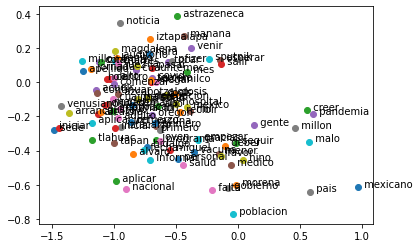

In [26]:
import gensim
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

modelo = gensim.models.Doc2Vec.load('d2vfinal_10.model')

palabras = []
etiquetas_palabras = []

for palabra in modelo.wv.key_to_index:        
    palabras.append(modelo.wv[palabra])
    etiquetas_palabras.append(palabra)
    
print('Añadidas %s palabras. Dimensión %s'%(len(palabras),np.shape(palabras)))

pca = PCA(n_components = 3)
pca.fit(palabras)
reducción = pca.transform(palabras)
 
for i, vec in enumerate(reducción):
    if i < 100:
        x,y = vec[0],vec[1]
        plt.scatter(x,y)
        plt.annotate(etiquetas_palabras[i],xy=(x,y))
        
plt.show()

# Método del codo para saber el número óptimo de grupos

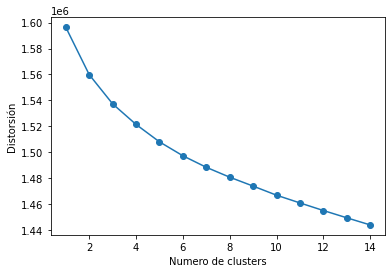

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.models.doc2vec import Doc2Vec

def kmeans_cluster(datos_doc2vec):    
    distortions = []

    for i in range(1,15):
        km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10 , max_iter = 300, random_state=0)
        km.fit(datos_doc2vec)
        distortions.append(km.inertia_)
        
    plt.plot(range(1,15), distortions, marker='o')
    plt.xlabel('Numero de clusters')
    plt.ylabel('Distorsión')
    plt.show()
    
entrenamiento = pd.read_csv('entrenamiento_final.csv')

tweets = entrenamiento['rawContent']

modelo = gensim.models.Doc2Vec.load('d2vfinal_v2_10.model')
datos_doc2vec = np.array([modelo.dv[i] for i in range(len(tweets))])
kmeans_cluster(datos_doc2vec)

# Método de la silueta para saber el número óptimo de grupos

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

número_clusters = range(2,12)

lista_inercia = []
lista_umbral = []
lista_kmn = []

for k in número_clusters:
    kmn = KMeans(n_clusters = k, random_state = 2020, max_iter = 100, n_init = 10)
    kmn.fit(datos_doc2vec)
    etiquetas = kmn.predict(datos_doc2vec)
    lista_inercia.append(kmn.inertia_)
    lista_umbral.append(silhouette_score(datos_doc2vec, etiquetas))
    lista_kmn.append(kmn)
    print('número de cluster: ', k)

número de cluster:  2
número de cluster:  3
número de cluster:  4
número de cluster:  5
número de cluster:  6
número de cluster:  7
número de cluster:  8
número de cluster:  9
número de cluster:  10
número de cluster:  11


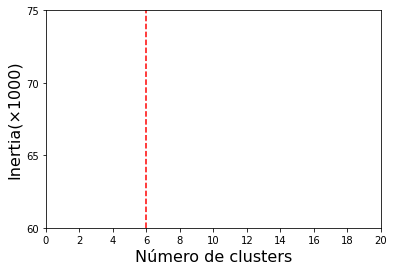

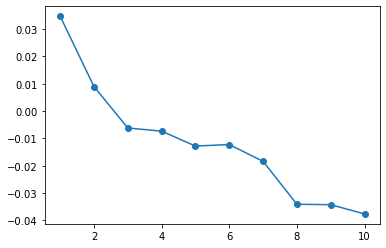

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1, len(lista_inercia) + 1), [i / 1000 for i in lista_inercia], marker= 'o', linestyle='-')
plt.ylim(60,75)
plt.xlim(0,20)    
plt.axvline(6, 0, 90, linestyle='--', c='red')
plt.xlabel("Número de clusters", fontsize=16)
plt.ylabel('Inertia(×1000)', fontsize=16)
plt.xticks(np.arange(0, 22, step=2))
plt.yticks(np.arange(60, 80, step=5))   
plt.figure()
plt.plot(range(1, len(lista_umbral)+1), lista_umbral, marker= 'o', linestyle='-')

# Aplicación del algoritmo K-Means

In [85]:
import pandas as pd

entrenamiento = pd.read_csv('entrenamiento_final2.csv')
#print(entrenamiento.head())

tweets = entrenamiento['rawContent']
urls = entrenamiento['url']
datos_preprocesados = entrenamiento['tweet_tokenizado']
dias = entrenamiento['dias']
meses = entrenamiento['meses']
años = entrenamiento['aÃÂ±os']
terminos = entrenamiento['termino']
latitudes = entrenamiento['latitudes']
longitudes = entrenamiento['longitudes']
alcaldias = entrenamiento['alcaldia']

In [86]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import gensim
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import pickle

def kmeans_cluster(datos_doc2vec, número_clusters):
    kmn = KMeans(n_clusters = número_clusters, random_state = 1010, max_iter=100, n_init='auto')
    kmn.fit(datos_doc2vec)
    labels = kmn.labels_
    
    with open('kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmn, f)
        
    #print(metrics.silhouette_score(datos_doc2vec, labels, metric='euclidean'))
    sample_silhouette_values = metrics.silhouette_samples(datos_doc2vec, labels)

    means_lst = []
    for label in range(número_clusters):
        means_lst.append(sample_silhouette_values[labels == label].mean())
    
    print(means_lst)
    
    etiquetas = kmn.predict(datos_doc2vec)

    return kmn, etiquetas

modelo = gensim.models.Doc2Vec.load('d2vfinal_v2_10.model')
datos_doc2vec = np.array([modelo.dv[i] for i in range(len(tweets))])

número_clusters = 6
kmn, etiquetas = kmeans_cluster(datos_doc2vec, número_clusters)
   
clusters = []
lista_latitudes = []
lista_longitudes = []
lista_alcaldias = []
lista_urls = []
lista_tweets = []
lista_dias = []
lista_meses = []
lista_años = []
lista_terminos = []

for n in range(número_clusters):
    clusters.append([datos_preprocesados[i] for i, e in enumerate(etiquetas) if e == n])
    lista_latitudes.append([latitudes[i] for i, e in enumerate(etiquetas) if e == n])
    lista_longitudes.append([longitudes[i] for i, e in enumerate(etiquetas) if e == n])
    lista_alcaldias.append([alcaldias[i] for i, e in enumerate(etiquetas) if e == n])
    lista_urls.append([urls[i] for i, e in enumerate(etiquetas) if e == n])
    lista_tweets.append([tweets[i] for i, e in enumerate(etiquetas) if e == n])
    lista_dias.append([dias[i] for i, e in enumerate(etiquetas) if e == n])
    lista_meses.append([meses[i] for i, e in enumerate(etiquetas) if e == n])
    lista_años.append([años[i] for i, e in enumerate(etiquetas) if e == n])
    lista_terminos.append([terminos[i] for i, e in enumerate(etiquetas) if e == n])

[0.08876776, -0.017967299, -0.09098179, 0.0004674577, -0.10163449, 0.07449466]


# Guarda los clusters encontrados en formato csv

In [46]:
número_clusters = 6

for i in range(número_clusters):
    cluster = []
    latitudes = []
    longitudes = [] 
    alcaldias = []
    urls = []
    tweets = []
    dias = []
    meses = []
    años = []
    terminos = []
    
    
    for tweet_tokenizado in clusters[i]:
        cluster.append(tweet_tokenizado)

    for lon in lista_longitudes[i]:
        longitudes.append(lon)

    for lat in lista_latitudes[i]:
        latitudes.append(lat)
        
    for alcaldia in lista_alcaldias[i]:
        alcaldias.append(alcaldia)
        
    for url in lista_urls[i]:
        urls.append(url)

    for tweet in lista_tweets[i]:
        tweets.append(tweet)
        
    for dia in lista_dias[i]:
        dias.append(dia)

    for mes in lista_meses[i]:
        meses.append(mes)
    
    for año in lista_años[i]:
        años.append(año)
    
    for termino in lista_terminos[i]:
        terminos.append(termino)

    textos = []
    texto = ""
    
    for tweet in cluster:
        for c in tweet:
            c = c.strip()
            texto += c
            #texto += " "
    
        textos.append(texto)
        texto = ""

    df = pd.DataFrame({'url' : urls, 'tweet': tweets, 'tweet_tokenizado': textos, 'dia' : dias, 
                       'mes': meses, 'año': años, 'latitud': latitudes, 'longitud': longitudes, 'alcaldia': alcaldias, 'termino': terminos})
    #df.columns = ['urls', 'tweet_tokenizado', 'textos', 'dias', 'meses', 'años', 'latitudes', 'longitudes']
    df.to_csv('cbow2/cluster_finalN-{}.csv'.format(i), index=False, encoding='utf-8')

# Predecir nuevos datos modelo K-Means

In [ ]:
import pickle
import gensim
import numpy as np
import pandas as pd

# Load the saved KMeans model
with open('kmeans_model.pkl', 'rb') as file:
    kmn = pickle.load(file)
    
prueba = pd.read_csv('pruebas_final_final.csv')
#print(entrenamiento.head())
tweets = prueba['rawContent']
print(kmn.n_clusters)
modelo = gensim.models.Doc2Vec.load('modelo_pruebas.model')
datos_doc2vec = np.array([modelo.dv[i] for i in range(len(tweets))])

etiquetas = kmn.predict(datos_doc2vec)

cluster = (etiquetas == 5)

cluster_data = prueba[cluster].iloc[:, [1, 2, 13, 17, 18, 19, 20, 21, 22, 23]]

print(cluster_data.count())

cluster_data.to_csv('datos_prueba_cluster_5_nv.csv', index = True, encoding='utf-8')

# Lectura del dataset final para aplicar topic Modeling con el fin de averiguar patrones

In [29]:
import pandas as pd
import regex as re

archivo = pd.read_csv("dataset_efectos_vacuna_covid_final.csv", encoding='latin-1')

tweets_nb = archivo['tweet_tokenizado']

textos = []

puntuaciones = "]'["
textos = []

i = 0

for tweet in tweets_nb:
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet)
    
    texto = tweet.replace(',','')
    #print(texto)
    
    if 'tocar' in texto:
        textos.append(texto)
        i += 1

print(i)
lista_documentos = []

for doc in textos:
    lista_documentos.append(doc.rstrip().split(' '))
    
print(lista_documentos)

6319
[['tocar', 'vacuna', 'nino', 'ano', 'llegar', 'centro', 'salud', 'terminar', 'esperar', 'ronda', 'rezagados', 'secretaria', 'salud', 'pensar', 'frasco', 'cubrir', 'poblacion', 'alvaro', 'oregon', 'nino', 'votar'], ['aplicar', 'vacuna', 'refuerzo', 'ano', 'alcaldia', 'miguel', 'hidalgo', 'alvaro', 'oregon', 'sede', 'tocar', 'horario'], ['senor', 'senorito', 'noche', 'aplicar', 'vacuna', 'refuerzo', 'joven', 'ano', 'alcaldia', 'miguel', 'hidalgo', 'alvaro', 'oregon', 'vacuna', 'tocar', 'sede'], ['atencion', 'joven', 'ano', 'ciudad', 'mexico', 'semana', 'tocar', 'vacuna', 'alvaro', 'oregon', 'estadio', 'cu'], ['estadio', 'olimpico', 'universitario', 'primero', 'aplicacion', 'dosis', 'refuerzo', 'vacuna', 'persona', 'ano', 'alvaro', 'oregon', 'cuauhtemoc', 'millo', 'alto', 'tocar', 'apellido', 'pater', 'iniciar'], ['sede', 'tercero', 'vacuna', 'alvaro', 'oregon', 'tocar', 'lunes'], ['tocar', 'vacuna', 'refuerzo', 'alcaldia', 'alvaro', 'oregon', 'gracias'], ['noche', 'sobrina', 'vivir'

## Lectura de los clusters

# Topic Modeling datos de clusters

In [ ]:
import pandas as pd
import regex as re

nombre_archivo = "cluster5.csv"

df_tw = pd.read_csv(nombre_archivo)

tweets = df_tw['tweet_tokenizado']

puntuaciones = "]'["
textos = []

i = 0

for tweet in tweets:
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet)
    
    #texto = tweet.replace(' ','')
    texto = tweet.replace(',','')
    
    textos.append(texto.lstrip())
    
    i += 1

df_tw['tweet_tokenizado'] = textos

In [48]:
documentos = df_tw['tweet_tokenizado'].tolist()

In [ ]:
lista_documentos = []

for doc in documentos:
    lista_documentos.append(doc.rstrip().split(' '))
    
print(lista_documentos)

In [17]:
def generar_bigramas(tweet_tokenizado):
    i = 0
    
    tamañio = len(tweet_tokenizado)
    palabras = tweet_tokenizado
    
    for palabra in palabras:
        if palabra == 'dolor':
            if not (i + 1 == tamañio):
               
                if palabras[i + 1] == 'pierna':
                    palabras[i] = 'dolor pierna'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'brazo':
                    
                    palabras[i] = 'dolor brazo'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'cabeza':
                    palabras[i] = 'dolor cabeza'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'muscular':
                    palabras[i] = 'dolor muscular'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'articular':
                    palabras[i] = 'dolor articular'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'cuerpo':
                    palabras[i] = 'dolor cuerpo'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                elif palabras[i + 1] == 'garganta':
                    palabras[i] = 'dolor garganta'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
        if palabra == 'dificultad':
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'respirar':
                    palabras[i] = 'dificultad respirar'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
        if palabra == 'cuerpo':
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'cortado':
                    palabras[i] = 'cuerpo cortado'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                if palabras[i + 1] == 'cortar':
                    palabras[i] = 'cuerpo cortado'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                    
        if palabra == 'irritacion':
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'brazo':
                    palabras[i] = 'irritacion brazo'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1] 
        
        if palabra == 'inflamacion':
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'brazo':
                    palabras[i] = 'inflamacion brazo'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
        
        if palabra == 'hinchazon':
            if not (i + 1 == tamañio):
                if palabras[i + 1] == 'brazo':
                    palabras[i] = 'hinchazon brazo'
                    
                    tamañio = tamañio - 1
                    del palabras[i + 1]
                        
        i += 1
        
    return palabras

aux_lista = []
for doc in lista_documentos:
    aux_lista.append(generar_bigramas(doc))
    
print(aux_lista[0])

['saludo', 'hermano', 'acompane', 'mama', 'benito', 'juez', 'tocar', 'astrazeneca', 'presentar', 'reaccion', 'vacuna', 'dolor cuerpo', 'dolor', 'articulacion', 'dolor cabeza', 'paracetamol', 'librar']


In [18]:
lista_documentos = aux_lista

# Diagrama nube de palabras para un cluster

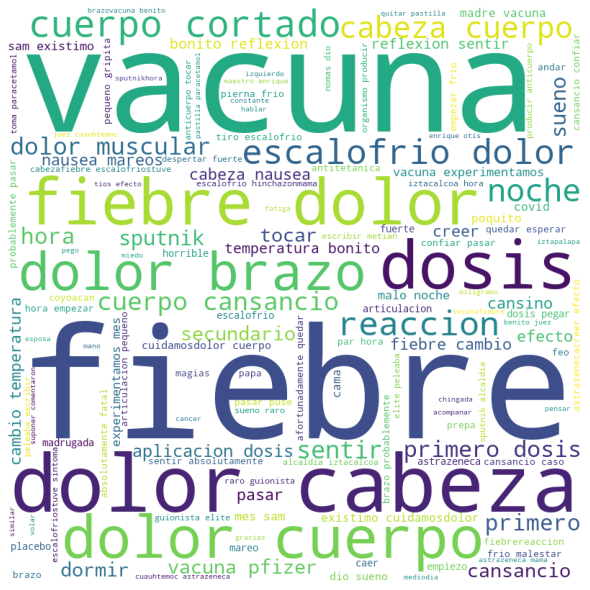

In [8]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

#archivo = pd.read_csv("cluster-4.csv", encoding = "ISO-8859-1", sep='\t', header=None)

#cluster = archivo[0]

tweets = " "

#for c in cluster:
    #tweets = tweets + c.replace(","," ")
for documento in textos:
    tweets = tweets + documento
    
nube_palabras = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(tweets)
                        
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(nube_palabras)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Topic Modeling LDA

In [30]:
from gensim import corpora

# create dictionary
dictionary = corpora.Dictionary(lista_documentos)
#dictionary.filter_extremes(no_below = 20, no_above=0.5)
#del_ids = [k for k,v in dictionary.items() if v=='jaja' or v=='jajaja' or v == 'ja' or v=='xd' or v=='wey' or v=='mexico' or v=='influenza' or
          #v == 'gracias' or v == 'dios' or v=='casa' or v=='cosa' or v=='pendejo' or v=='eh' or v=='virus' or v=='caso' or v == 'ah' or v=='ta' or
          #v=='to' or v=='is' or v=='positivo' or v=='doctor' or v=='prueba' or v=='amigo' or v=='city' or v=='ta' or v=='jajajaja' or v=='mundo' or
          #v=='contagio' or v=='variante' or v=='sa' or v=='saludo']


del_ids = [k for k,v in dictionary.items() if v=='vacuna' or v=='dosis' or v == 'tocar']
           
dictionary.filter_tokens(bad_ids=del_ids)

# create document term matrix
bow = [dictionary.doc2bow(texto) for texto in lista_documentos]

# Número óptimo de temas

In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np 

best_num = float('NaN')
best_score = 0

# compute the coherence scores for each number of topics
for i in range(2,12):
    
    # create lda model with i topics
    lda = LdaModel(corpus=bow, num_topics=i, id2word=dictionary, passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
    
    # obtain the coherence score
    coherence_model = CoherenceModel(model=lda, texts=lista_documentos, dictionary=dictionary, coherence='c_v')
    coherence_score = np.round(coherence_model.get_coherence(),2)
    if coherence_score > best_score:
        best_num = i
        best_score = coherence_score

print(f'The coherence score is highest ({best_score}) with {best_num} topics.')

# Entrenamiento

In [25]:
import gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                           id2word=dictionary,
                                           num_topics=9, 
                                           passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

# Visulización de temas

In [26]:
for topic in lda_model.print_topics(num_words=100):
    print(topic)

(0, '0.046*"primero" + 0.040*"ano" + 0.031*"alcaldia" + 0.024*"acudir" + 0.023*"cuauhtemoc" + 0.022*"oregon" + 0.020*"adulto" + 0.019*"alvaro" + 0.019*"covid" + 0.016*"persona" + 0.012*"iztapalapa" + 0.011*"centro" + 0.011*"esquema" + 0.010*"salud" + 0.009*"refuerzo" + 0.009*"juez" + 0.008*"benito" + 0.008*"apellido" + 0.007*"mujer" + 0.006*"sede" + 0.006*"atencion" + 0.006*"nino" + 0.006*"pfizer" + 0.006*"embarazado" + 0.006*"hora" + 0.006*"llegar" + 0.006*"cita" + 0.006*"xochimilco" + 0.006*"completar" + 0.005*"sanitario" + 0.005*"pasar" + 0.005*"arrancar" + 0.005*"corresponder" + 0.005*"venusianos" + 0.005*"aplicacion" + 0.005*"iniciar" + 0.005*"edad" + 0.005*"junio" + 0.004*"anti" + 0.004*"unidad" + 0.004*"jurisdiccion" + 0.004*"miercoles" + 0.004*"asistir" + 0.004*"mayo" + 0.004*"astrazeneca" + 0.004*"manana" + 0.004*"semana" + 0.004*"letra" + 0.004*"tapan" + 0.004*"deber" + 0.004*"gracias" + 0.004*"comprobante" + 0.003*"jueves" + 0.003*"nina" + 0.003*"residir" + 0.003*"completo" 

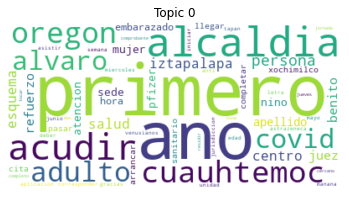

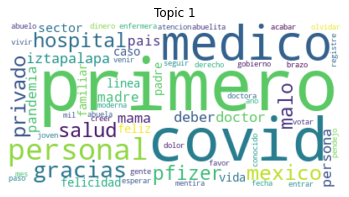

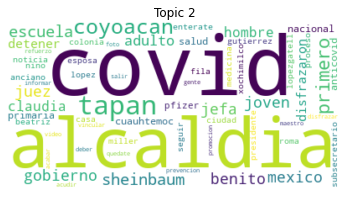

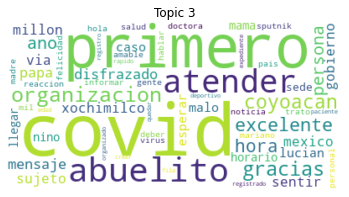

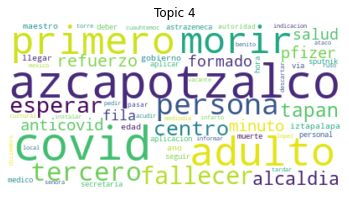

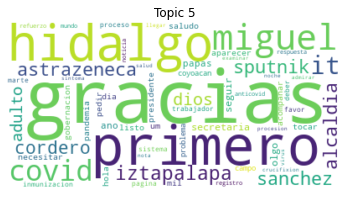

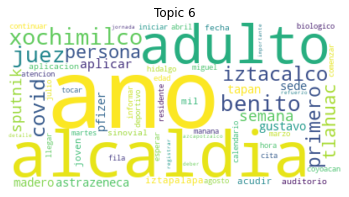

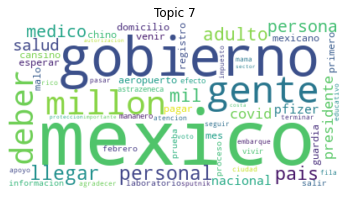

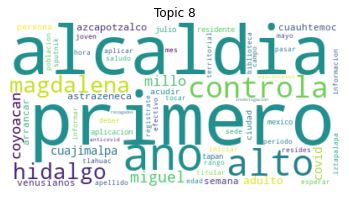

IndexError: index 9 is out of bounds for axis 0 with size 9

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic,60)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

for i in range(0,12):
    create_wordcloud(lda_model, topic=i)

In [14]:
#!pip install pyldavis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis,'lda.html')
vis

C:\Users\erick\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.199667  0.093757       1        1  53.688813
1      0.073062 -0.189530       2        1  17.362554
3     -0.057194  0.099594       3        1  16.862643
2     -0.215535 -0.003821       4        1  12.085990, topic_info=          Term          Freq         Total Category  logprob  loglift
7       vacuna  10521.000000  10521.000000  Default  30.0000  30.0000
58       dosis   7725.000000   7725.000000  Default  29.0000  29.0000
3      aplicar   9694.000000   9694.000000  Default  28.0000  28.0000
2          ano   3794.000000   3794.000000  Default  27.0000  27.0000
0     alcaldia   2632.000000   2632.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
555   personal     55.123391    217.719568   Topic4  -5.7098   0.7395
57       covid     80.140358   1652.507341   Topic4  -5.3356  -0.9131
91         mil     63.065944    596.866468   Topic4  -5.5752  -0.1344
203  poblacion     46.929607    219.016987   Topic4  -5.8708   0.5726
110    recibir     47.562826    465.265487   Topic4  -5.8574  -0.1674

[262 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
270       1  0.785599      acudir
270       3  0.213265      acudir
84        1  0.909689      adulto
84        3  0.066487      adulto
84        4  0.023612      adulto
...     ...       ...         ...
19        1  0.998140  venusianos
460       4  0.971596        voto
1900      2  0.978124  vulnerable
144       1  0.999322  xochimilco
1111      3  0.985049         xxi

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

# Obtener temas predominantes por documento

In [53]:
topic_dist = lda_model[bow]

# store distributions ina list
dist = []
for t in topic_dist:
    dist.append(t)

ndf = pd.DataFrame({'topics':dist})
ndf

,topics
0,"[(0, 0.9623008), (1, 0.037699215)]"
1,"[(0, 0.93566114), (1, 0.0643389)]"
2,"[(0, 0.16320585), (1, 0.83679414)]"
3,"[(0, 0.07668687), (1, 0.92331314)]"
4,"[(0, 0.10981817), (1, 0.89018184)]"


In [20]:
ndf.to_csv('topics.csv',index=False)

# Guardar modelo LDA

In [ ]:
lda_model.save('cbow/lda_topicos')
dictionary.save('cbow/dictionary')
bow.save('cbow/bow')

In [1]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Load the dictionary
#dictionary = Dictionary.load('path/to/dictionary')

# Load the LDA model
lda_model = LdaModel.load('lda_10_topicos')

# Agrupar los documentos por su tema predominante 

In [91]:
import pandas as pd

def format_topics_sentences(ldamodel, corpus, text, urls, tweet, dias, meses, años, latitudes, longitudes, terminos, alcaldias):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    contents = pd.Series(text)
    sent_topics_df = pd.concat([sent_topics_df, contents, urls, tweet, dias, meses, años, latitudes, longitudes, alcaldias, terminos], axis=1)
    return(sent_topics_df)
    

urls = df_tw['url']
tweet = df_tw['tweet']
dias = df_tw['dia']
meses = df_tw['mes']
años = df_tw['año']
latitudes = df_tw['latitud']
longitudes = df_tw['longitud']
terminos = df_tw['termino']
alcaldias = df_tw['alcaldia']

df_topic_sents_keywords = format_topics_sentences(lda_model, bow, lista_documentos, urls, tweet, dias, meses, años, latitudes, longitudes, terminos, alcaldias)

In [ ]:
df_topic_sents_keywords.loc[2653]

In [107]:
dtn = df_topic_sents_keywords.loc[(df_topic_sents_keywords['Dominant_Topic'] == 10.0)]
dtn.to_csv('cbow/final10.csv')

# Comprobar si son posibles efectos secundarios

In [35]:
import pandas as pd
import regex as re

nombre_archivo = "cluster-3.csv"

df_tw = pd.read_csv(nombre_archivo)

tweets_tokenizados = df_tw['tweet_tokenizado']
urls = df_tw['url']
tweets = df_tw['tweet']
dias = df_tw['dia']
meses = df_tw['mes']
años = df_tw['año']
latitudes = df_tw['latitud']
longitudes = df_tw['longitud']
alcaldias = df_tw['alcaldia']
terminos = df_tw['termino']

puntuaciones = "]'["
textos = []

i = 0

for tweet in tweets_tokenizados:
    tweet = re.sub('[' + puntuaciones + ']+', '', tweet)
    
    texto = tweet.replace(',','')
    
    textos.append(texto)
    
    i += 1

#texto = textos[7]

marcas_vacuna = ['sputnik', 'sputnikv', 'astrazeneca', 'pfizer', 'moderna', 'sinovac', 'johnson johnson', 
                 'biontech','pfizerbiontech', 'cansino','janssen','johnson']

efectos_secundarios = ['fiebre', 'dolor cabeza', 'dolor brazo', 'cansancio', 'escalofrios', 
                      'nauseas', 'dolor muscular', 'dolor articulaciones', 'sudores', 'mareos',
                      'sueno', 'nausea', 'mareo', 'dolor articular',
                      'escalofrio', 'temperatura', 'cuerpo cortado', 'colico', 'menstrual', 
                       'menstruaccion', 'dolor garganta', 'gripe', 'gripa', 'fatiga',
                       'cansado', 'pereza', 'dolor articulacion', ' frio', 'sudor', 'dolor cuerpo']

palabras = ['vacuna', 'dosis', 'refuerzo']

cols = df_tw.columns#[5:]

# create a new empty DataFrame with the desired columns
df1 = pd.DataFrame(columns=cols)
df1['efecto'] = ""
df1['marca_vacuna'] = ""

df2 = pd.DataFrame(columns=['entidad'])

k = 0
for j, texto in enumerate(textos):     
    entidad = ()
    nombre = ""
    
    for palabra in palabras:
        comienzo = texto.find(palabra)

        if comienzo != -1:
            i += 1
            fin = comienzo + len(palabra) - 1
            
            entidad = (texto, {"entities": [(comienzo, fin, "VACUNA")]})

    for marca in marcas_vacuna:
        comienzo = texto.find(marca)

        if comienzo != -1:
            fin = comienzo + len(marca) - 1
            
            if len(entidad) != 0:
                #print(texto)
                entidad[1]["entities"].append((comienzo, fin, 'MARCA_VACUNA'))  
                #(texto, {"entities": [(comienzo, fin, "MARCA")]})
            else:
                entidad = (texto, {"entities": [(comienzo, fin, "MARCA_VACUNA")]})
                
            nombre = marca
    
    bandera = False
    
    if len(entidad) != 0:
        for efecto in efectos_secundarios:
            comienzo = texto.find(efecto)

            if comienzo != -1:
                fin = comienzo + len(efecto) - 1
                entidad[1]["entities"].append((comienzo, fin, 'EFECTO_SECUNDARIO'))  
                bandera = True
                
                if efecto == 'menstrual':
                    efecto = 'ciclo menstrual'
               
                df1.loc[i,'tweet_tokenizado'] = texto
                df1.loc[i,'tweet'] = tweets[j]
                df1.loc[i,'url'] = urls[j]
                df1.loc[i,'dia'] = dias[j]
                df1.loc[i,'mes'] = meses[j]
                df1.loc[i,'año'] = años[j]
                df1.loc[i,'longitud'] = longitudes[j]
                df1.loc[i,'latitud'] = latitudes[j]
                df1.loc[i,'alcaldia'] = alcaldias[j]
                df1.loc[i,'termino'] = terminos[j]
                df1.loc[i,'efecto'] = efecto
                df1.loc[i,'marca_vacuna'] = nombre
                #df1.loc[i,'entidad'] = entidad_vacuna
                
                i += 1
    if bandera:
        df2.loc[i,'entidad'] = entidad
        j += 1
        
df1.to_csv('d_c3.csv',index=False,encoding='utf-8')
df2.to_csv('d_e_c3.csv',index=False,encoding='utf-8')

# Corregir datos del dataset final de posibles efectos secundarios por la vacuna COVID-19

In [7]:
import pandas as pd

df = pd.read_csv('a.csv')

efectos = df['efecto']
meses = df['mes']

dicc_meses = {1: 'enero', 2: 'febrero', 3: 'marzo', 4: 'abril', 5: 'mayo', 6: 'junio', 
                  7: 'julio', 8: 'agosto', 9: 'septiembre', 10: 'octubre', 11: 'noviembre', 12: 'diciembre'}

for i,efecto in enumerate(efectos):
    if efecto == 'sueno':
        df.loc[i,'efecto'] = 'sueño'
    

for i,mes in enumerate(meses):
    periodo = dicc_meses[int(mes)]
    df.loc[i,'mes'] = periodo
    
df.to_csv('efectos_dataset_final.csv',encoding='utf-8',index=False)

# Conteo de la cantidad de términos extraídos

In [6]:
import collections
import pandas as pd

tweets = pd.read_csv('nv_dataset_vacuna.csv', encoding='ISO-8859-1')
términos = tweets['termino']

conteo = collections.Counter(términos)

elementos_ordenados = sorted(conteo.items(), key=lambda x: x[1])
print(len(elementos_ordenados))
print(elementos_ordenados)

134
[('"recibamos vacuna"', 1), ('"recibamos dosis"', 1), ('"sentiamos vacuna"', 1), ('"pongamos dosis"', 1), ('"pongamos vacuna"', 1), ('"vacuna refuerzo"', 1), ('"flujo vacuna"', 1), ('"recupero vacuna"', 1), ('"recuperado vacuna"', 1), ('"recuperar dosis"', 1), ('"recupero dosis"', 1), ('"recuperado dosis"', 1), ('"tumbar vacuna"', 1), ('"experimento dosis"', 1), ('"mori vacuna"', 1), ('"mori dosis"', 1), ('"afectando vacuna"', 1), ('"afecto dosis"', 1), ('"sensacion dosis"', 1), ('"efecto pfizer"', 1), ('"inyecte dosis"', 1), ('"ciclo vacuna"', 1), ('"tocar dosis"', 2), ('"cansado vacuna"', 2), ('"cansado dosis"', 2), ('"fatiga vacuna"', 2), ('"recuperar vacuna"', 2), ('"recupere vacuna"', 2), ('"ciclo dosis"', 2), ('"tocado dosis"', 3), ('"sintio dosis"', 3), ('"ponga dosis"', 3), ('"mareos vacuna"', 3), ('"aguantar vacuna"', 3), ('"molestia dosis"', 3), ('"horrible dosis"', 3), ('"tumbo vacuna"', 3), ('#janssen', 3), ('"ansiedad vacuna"', 3), ('"potente dosis"', 4), ('"mareo vacu